## import modules

In [1]:
# Import basic modules
# More modules will be imported before the corresponding function
# import logging # logger = logging.getLogger(__name__)
import math
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") # Ignore some annoying warnings
from datetime import datetime

# Import module for EMD decomposition
# It is the EMD-signal module with different name to import
from PyEMD import EMD,EEMD,CEEMDAN,Visualisation #For module 'PyEMD', please use 'pip install EMD-signal' instead.

# Import module for sample entropy
from sampen import sampen2

# Import modules for LSTM prediciton
# Sklearn
from sklearn.preprocessing import MinMaxScaler # Normalization
from sklearn.metrics import r2_score # R2
from sklearn.metrics import mean_squared_error # MSE
from sklearn.metrics import mean_absolute_error # MAE
from sklearn.metrics import mean_absolute_percentage_error # MAPE
# Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.layers import GRU,Flatten
#from tcn import TCN # pip install keras-tcn

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model # To use plot_model, you need to install software graphviz
from tensorflow.python.client import device_lib

# Statistical tests
from statsmodels.tsa.stattools import adfuller # adf_test
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test # LB_test
from statsmodels.stats.stattools import jarque_bera as jb_test # JB_test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # plot_acf_pacf

from sklearn.preprocessing import StandardScaler

In [2]:
#import dataset
data = pd.read_excel('/Users/tiantianzhang/Desktop/patient/p4/p4.xlsx', usecols=[2,5])
#data = data.reindex(index = data.index[::-1])

In [3]:
data.head()

,ReadingDt,SensorGLU
0,2000-02-23,40
1,2000-02-23,40
2,2000-02-23,40
3,2000-02-23,45
4,2000-02-23,49


In [4]:
CGMS = pd.Series(data['SensorGLU'])
CGMS

0       40
1       40
2       40
3       45
4       49
        ..
1775    82
1776    73
1777    66
1778    40
1779    40
Name: SensorGLU, Length: 1780, dtype: int64

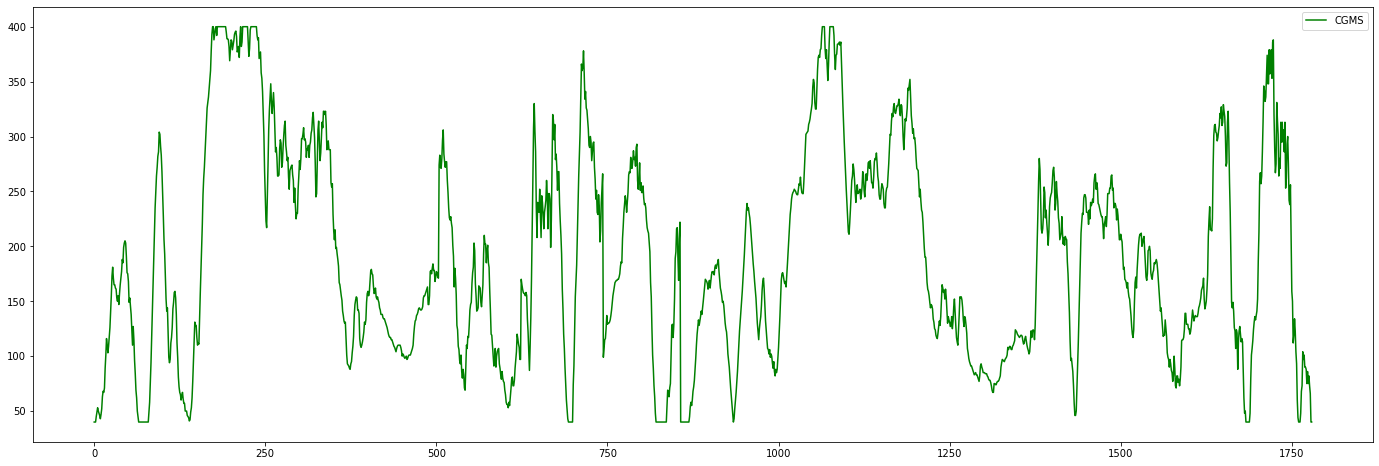

In [5]:
# PLOTTING 
plt.figure(figsize=(24,8))
plt.plot( CGMS, 'g', label = 'CGMS')
plt.legend(loc = 'upper right')
plt.show()

In [6]:
# Model variables
# -------------------------------
# Mainly determine the decomposition method 
MODE = 'emd' 
# Integration form only effective after integration

# 2. EMD decompose data

In [293]:
# 3.Decomposition, Sample entropy, Re-decomposition, and Integration
#==============================================================================================

# EMD decomposition
# -------------------------------
# Decompose adaptively and plot function
# Residue is named the last IMF
# Declare MODE by declare_vars first
def emd_decom(s1,trials=10,re_decom=False,re_imf=0,draw=True): 
    # Check input
    #dataset,file_name = check_dataset(series,input_form='series') # include check_vars()
    #series = series.values
    series = s1.values
    #series = s1

    # Initialization
    print('%s decomposition is running.'%str.upper(MODE))
    if MODE == 'emd':
        decom = EMD(std_thr=0.01, range_thr=0.05)
        #decom.FIXE = 5
        #decom.FIXE_H = 10
    elif MODE == 'eemd':
        decom = EEMD()
    elif MODE == 'ceemdan':
        decom = CEEMDAN()
    else: 
        raise ValueError('MODE must be emd, eemd, ceemdan when EMD decomposing.')

    # Decompose
    #decom.trials = trials # Number of the white noise input
    imfs_emd = decom(series,max_imf = 8)
    imfs_num = np.shape(imfs_emd)[0]

    if draw:
        # Plot original data
        series_index = range(len(series))
        fig = plt.figure(figsize=(16,2*imfs_num))
        plt.subplot(1+imfs_num, 1, 1 )
        plt.plot(series_index, series, color='#0070C0') #F27F19 orange #0070C0 blue
        plt.ylabel('Original data')
    
        # Plot IMFs
        for i in range(imfs_num):
            plt.subplot(1 + imfs_num,1,2 + i)
            plt.plot(series_index, imfs_emd[i, :], color='#F27F19')
            plt.ylabel(str.upper(MODE)+'-IMF'+str(i))
 
        # Save figure
        #fig.align_labels()
        #plt.tight_layout()
        #if file_name == '':
            #if (re_decom==False): plt.savefig(FIGURE_PATH+file_name+str.upper(MODE)+' Result.svg', bbox_inches='tight')
            #else: plt.savefig(FIGURE_PATH+'IMF'+str(re_imf)+' '+str.upper(MODE)+' Re-decomposition Result.svg', bbox_inches='tight')
        plt.show()
    
    # Save data
    imfs_df = pd.DataFrame(imfs_emd.T)
    imfs_df.columns = ['imf'+str(i) for i in range(imfs_num)]
    #if file_name == '':
        #if (re_decom==False): 
            #pd.DataFrame.to_csv(imfs_df,PATH+file_name+MODE+'_data.csv')
            #print(str.upper(MODE)+' finished, check the dataset: ',PATH+file_name+MODE+'_data.csv')
    #PATH = '/Users/tiantianzhang/Desktop/patient/p4/'
    #file_name = 'p4_imfs'
    #pd.DataFrame.to_csv(imfs_df,PATH+file_name+MODE+'_data.csv')
    #print(str.upper(MODE)+' finished, check the dataset: ',PATH+file_name+MODE+'_data.csv')



    return imfs_df # pd.DataFrame

In [294]:
MODE

'emd'

EMD decomposition is running.


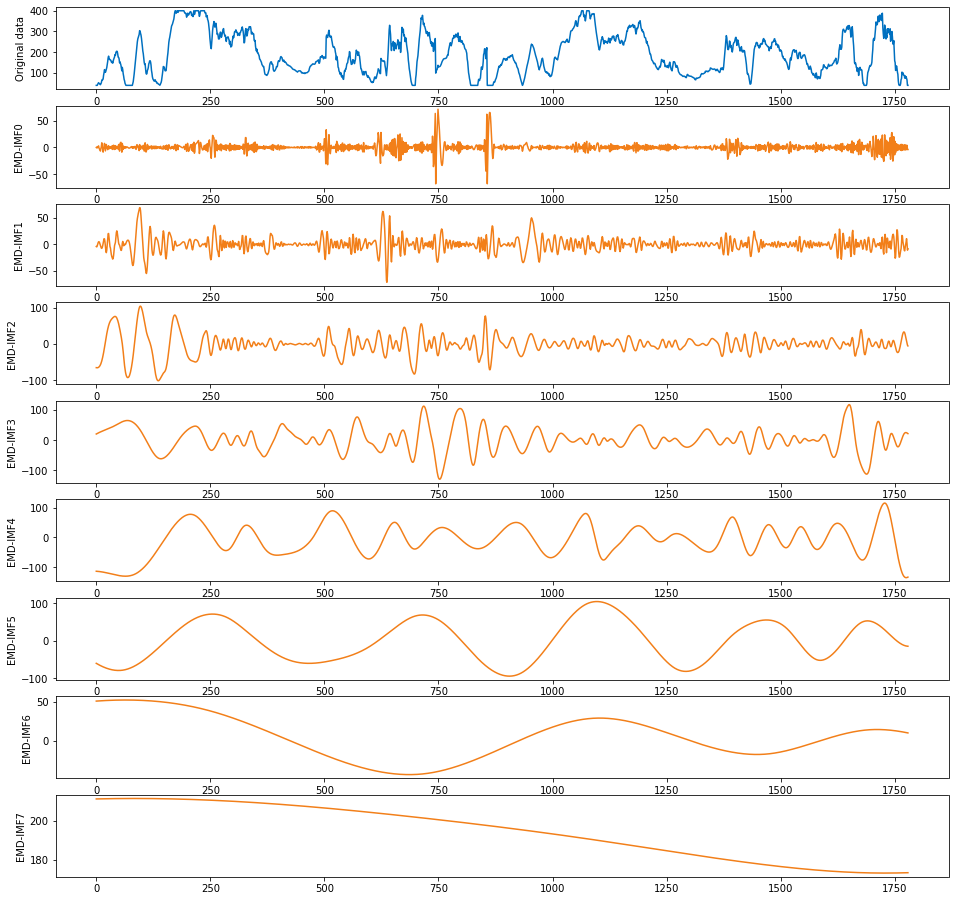

In [295]:
imfs = emd_decom(CGMS)

lst1 = ['imf0','imf1','imf2','imf3','imf4','imf5','imf6','imf7']
denoise_1 = ['imf1','imf2','imf3','imf4','imf5','imf6','imf7']
denoise_2 = ['imf2','imf3','imf4','imf5','imf6','imf7']
imfs['sum1'] = imfs[denoise_1].sum(axis = 1)
imfs['sum2'] = imfs[denoise_2].sum(axis = 1)
imfs['ogrinial data']= imfs[lst1].sum(axis = 1)
imfs

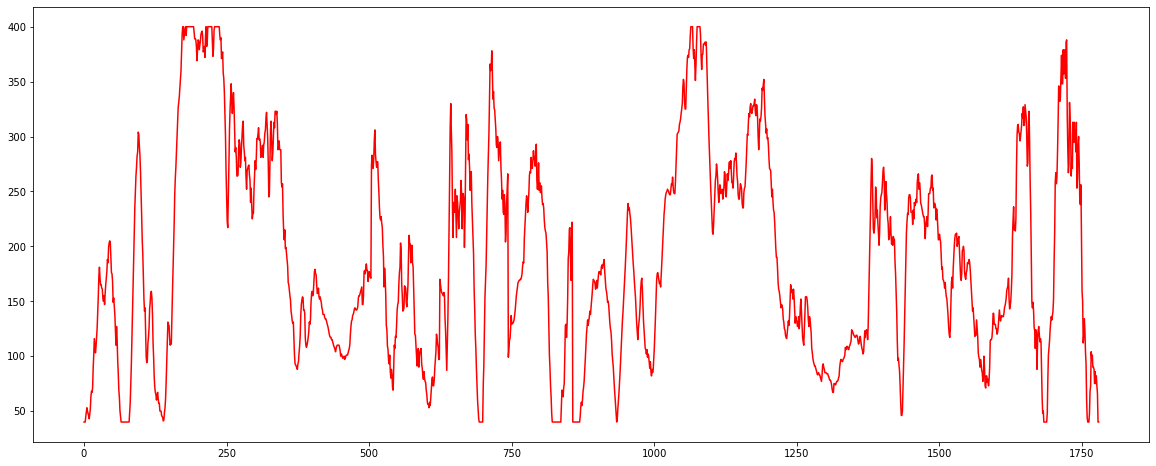

In [259]:
plt.figure(figsize = (20,8))
plt.plot(CGMS,'red')
#plt.plot(imfs['sum1'],'blue')
#plt.plot(imfs['sum2'],'green')

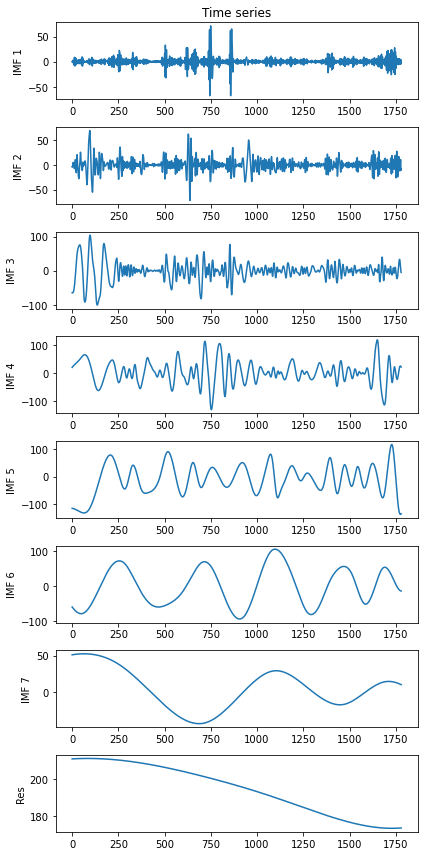

In [99]:


# Extract imfs and residue
# In case of EMD
emd = EMD()
emd.emd(CGMS.values)
imfs, res = emd.get_imfs_and_residue()

# In general:
#components = EEMD()(S)
#imfs, res = components[:-1], components[-1]

vis = Visualisation()
vis.plot_imfs(imfs=imfs, residue=res, include_residue=True)
#vis.plot_instant_freq(imfs=imfs)
vis.show()

# 3. Single-LSTM

In [11]:
CGMS_df = pd.DataFrame(data['SensorGLU'])
CGMS_df

,SensorGLU
0,40
1,40
2,40
3,45
4,49
...,...
1775,82
1776,73
1777,66
1778,40


In [12]:
def LSTM_Data_Precesing(df,mem_his_days,pre_days):
    #df.dropna(inplace=True)
    #df.sort_index(inplace=True)

    df['label'] = df.iloc[:][0:].shift(-pre_days)

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    sca_X = scaler.fit_transform(df.iloc[:,:-1])
    #print(type(sca_X))

    from collections import deque
    deq = deque(maxlen=mem_his_days)

    X = []
    for i in sca_X:
        deq.append(list(i))
        if len(deq)==mem_his_days:
            X.append(list(deq))

    X_lately = X[-pre_days:]
    X = X[:-pre_days]

    y = scaler.fit_transform(df.iloc[:,-1:])[mem_his_days-1:-pre_days]

    import numpy as np
    X = np.array(X)

    return X,y,X_lately

In [13]:
X,y,X_lately = LSTM_Data_Precesing(CGMS_df,20,1)

In [14]:
print(len(X))
print(len(y))
print(len(X_lately))

1760
1760
1


In [15]:
from sklearn.model_selection import train_test_split
X_train = X[0:1500]
X_test = X[1500:]
y_train = y[0:1500]
y_test = y[1500:]

In [16]:
#pre_days = 1
# mem_days = [5,10,15]
# lstm_layers = [1,2,3]
# dense_layers = [1,2,3]
# units = [16,32]
                
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(1,input_shape=X.shape[1:],return_sequences=True))
#model.add(Dropout(0.1))
                

model.add(LSTM(10))
#model.add(Dropout(0.1))

model.add(Dense(1))

model.compile(loss = 'mse')

2022-06-21 13:20:00.336480: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-21 13:20:00.338351: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 1)             12        
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 503
Trainable params: 503
Non-trainable params: 0
_________________________________________________________________


In [18]:
history_LSTM=model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test))

Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-21 13:20:03.321336: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_4350_4532' and '__inference___backward_standard_lstm_4645_5130_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_5837' both implement 'lstm_4cb0e83a-86c4-415b-8e63-584768a75c4d' but their signatures do not match.


1440/1500 [===========================>..] - ETA: 0s - loss: 0.7401

2022-06-21 13:20:06.767940: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_6122' and '__inference_standard_lstm_6122_specialized_for_sequential_lstm_StatefulPartitionedCall_at___inference_distributed_function_6920' both implement 'lstm_703da173-712d-4b5b-b33d-073942501c58' but their signatures do not match.


1500/1500 [==============================] - 5s 4ms/sample - loss: 0.7337 - val_loss: 0.5603
Epoch 2/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.5088 - val_loss: 0.5010
Epoch 3/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.4442 - val_loss: 0.4293
Epoch 4/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.3856 - val_loss: 0.3505
Epoch 5/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.3251 - val_loss: 0.2696
Epoch 6/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.2677 - val_loss: 0.2237
Epoch 7/50
1500/1500 [==============================] - 1s 997us/sample - loss: 0.2187 - val_loss: 0.2099
Epoch 8/50
1500/1500 [==============================] - 1s 986us/sample - loss: 0.1827 - val_loss: 0.1788
Epoch 9/50
1500/1500 [==============================] - 1s 996us/sample - loss: 0.1528 - val_loss: 0.2033
Epoch 10/50
1500/1500 [==============================] - 2s 1ms/sampl

In [19]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

2022-06-21 13:21:32.908190: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_13277_specialized_for_sequential_lstm_1_StatefulPartitionedCall_at___inference_distributed_function_13579' and '__inference_cudnn_lstm_with_fallback_13388' both implement 'lstm_ca76c99a-0529-4d87-be7c-ec085eb1a288' but their signatures do not match.


In [20]:
scaler = StandardScaler()
sca_X = scaler.fit_transform(CGMS_df.iloc[:,:-1])

In [21]:
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(y_test)

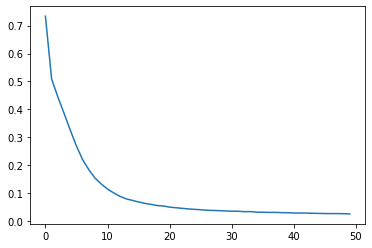

In [22]:
plt.plot(history_LSTM.history['loss'])

In [23]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
print('Train RMSE: %.2f' % (trainScore))

# TEST RMSE
testScore = math.sqrt(mean_squared_error(y_test, testPredict))
print('Test RMSE: %.2f' % (testScore))

Train RMSE: 14.88
Test RMSE: 18.17


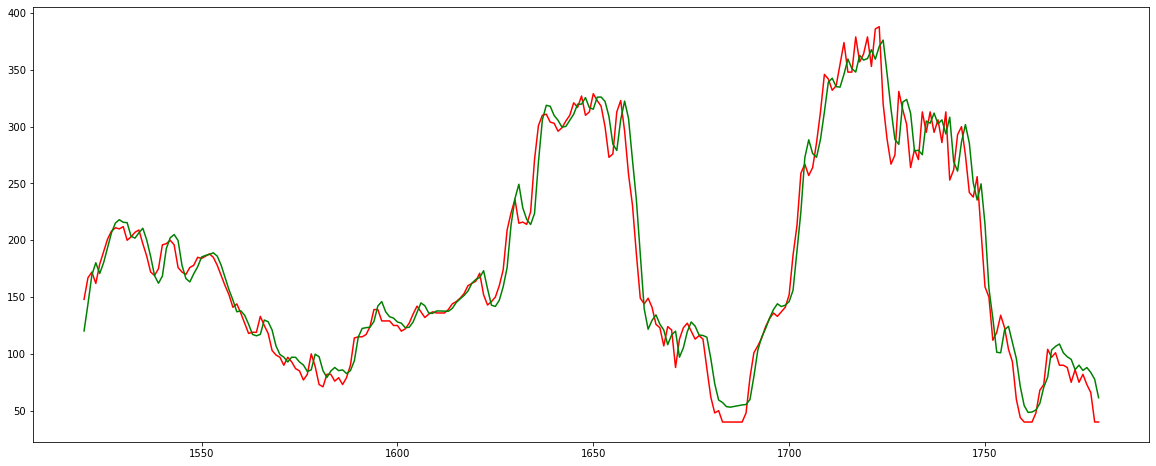

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
df_time = CGMS_df.index[-len(y_test):]
plt.plot(df_time,y_test,color='red',label='original data')
plt.plot(df_time,testPredict,color='green',label='predict')
plt.show()

# Multi-LSTM

In [270]:
imfs

,imf0,imf1,imf2,imf3,imf4,imf5,imf6,imf7
0,-0.102581,-3.943954,-64.796876,20.384439,-114.061662,-59.733687,51.107259,211.147062
1,0.765426,-4.594334,-65.083754,21.215467,-114.166665,-60.438311,51.149554,211.152617
2,-0.921463,-2.873972,-65.162935,22.027034,-114.285554,-61.132448,51.191231,211.158107
3,0.963772,0.067195,-65.010775,22.818457,-114.418547,-61.815923,51.232288,211.163534
4,1.559780,3.057513,-64.595093,23.590496,-114.565753,-62.488564,51.272724,211.168897
...,...,...,...,...,...,...,...,...
1775,4.152286,4.593890,13.515932,25.066089,-135.779070,-13.518668,10.497409,173.472132
1776,-3.994592,10.932561,6.999539,24.640384,-135.680262,-13.756998,10.380634,173.478735
1777,3.957909,2.387654,1.262856,23.888460,-135.298598,-13.946168,10.262413,173.485473
1778,-3.964227,-10.831149,-2.968564,22.877832,-134.662310,-14.086686,10.142759,173.492344


In [271]:
def LSTM_model(df,mem_his_days,pre_days,string):
    X0,y0,X0_lately = LSTM_Data_Precesing(df,20,1)
    
    X0_train = X0[0:1500]
    X0_test = X0[1500:]
    y0_train = y0[0:1500]
    y0_test = y0[1500:]
    
    
    model = Sequential()
    model.add(LSTM(1,input_shape=X0.shape[1:],return_sequences=True))
    #model.add(Dropout(0.1))
                
    model.add(LSTM(10))
    #model.add(Dropout(0.1))
    
    model.add(Dense(1))
    
    model.compile(loss='mse')
    
    model.fit(X0_train,y0_train,batch_size=32,epochs=50,validation_data=(X0_test,y0_test))
    
    
    trainPredict0 = model.predict(X0_train)
    testPredict0 = model.predict(X0_test)
    
    scaler = StandardScaler()
    sca_X0 = scaler.fit_transform(df[[string]])
    
    trainPredict0 = scaler.inverse_transform(trainPredict0)
    y0_train = scaler.inverse_transform(y0_train)
    testPredict0 = scaler.inverse_transform(testPredict0)
    y0_test = scaler.inverse_transform(y0_test)
    
    trainScore0 = math.sqrt(mean_squared_error(y0_train, trainPredict0))
    print('Train RMSE: %.2f' % (trainScore0))

    # TEST RMSE
    testScore0 = math.sqrt(mean_squared_error(y0_test, testPredict0))
    print('Test RMSE: %.2f' % (testScore0))
    
    plt.figure(figsize=(20,8))
    df_time = df.index[-len(y0_test):]
    plt.plot(df_time,y0_test,color='red',label='original data')
    plt.plot(df_time,testPredict0,color='green',label='predict')
    plt.show()
    return testPredict0

Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-21 17:16:25.473150: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_263896_264078' and '__inference___backward_standard_lstm_265192_265677_specialized_for_StatefulPartitionedCall_1_at___inference_distributed_function_265852' both implement 'lstm_2718981d-0559-4b11-80a8-2ffe6dca498d' but their signatures do not match.


1440/1500 [===========================>..] - ETA: 0s - loss: 1.0217

2022-06-21 17:16:28.920920: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_266717' and '__inference_standard_lstm_266606_specialized_for_sequential_19_lstm_39_StatefulPartitionedCall_at___inference_distributed_function_266935' both implement 'lstm_194eb881-a660-4cac-bd8d-f75dfd0d6fa7' but their signatures do not match.


1500/1500 [==============================] - 8s 5ms/sample - loss: 1.0146 - val_loss: 0.9605
Epoch 2/50
1500/1500 [==============================] - 1s 995us/sample - loss: 1.0113 - val_loss: 0.9629
Epoch 3/50
1500/1500 [==============================] - 1s 999us/sample - loss: 1.0088 - val_loss: 0.9625
Epoch 4/50
1500/1500 [==============================] - 1s 991us/sample - loss: 1.0062 - val_loss: 0.9646
Epoch 5/50
1500/1500 [==============================] - 1s 991us/sample - loss: 1.0038 - val_loss: 0.9645
Epoch 6/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 1.0014 - val_loss: 0.9672
Epoch 7/50
1500/1500 [==============================] - 1s 995us/sample - loss: 0.9987 - val_loss: 0.9708
Epoch 8/50
1500/1500 [==============================] - 5s 3ms/sample - loss: 0.9945 - val_loss: 0.9736
Epoch 9/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.9915 - val_loss: 0.9772
Epoch 10/50
1500/1500 [==============================] - 2s 1ms/s

2022-06-21 17:17:55.375321: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_273292' and '__inference_standard_lstm_273292_specialized_for_sequential_19_lstm_39_StatefulPartitionedCall_at___inference_distributed_function_273594' both implement 'lstm_f6e2df87-38eb-478f-a9d1-51078b0d8fa9' but their signatures do not match.


Train RMSE: 7.37
Test RMSE: 8.54


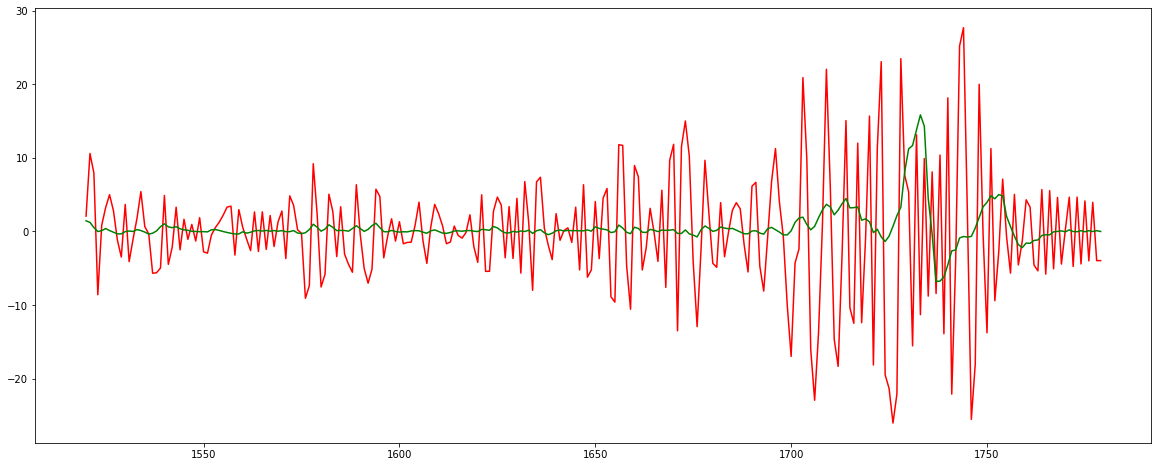

Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-21 17:17:57.908641: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_278877_279362' and '__inference___backward_standard_lstm_278877_279362_specialized_for_StatefulPartitionedCall_1_at___inference_distributed_function_279537' both implement 'lstm_88418ca6-69f9-4cd0-a078-0939fb20cd59' but their signatures do not match.


1440/1500 [===========================>..] - ETA: 0s - loss: 1.0448

2022-06-21 17:18:01.254417: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_279822' and '__inference_standard_lstm_279822_specialized_for_sequential_20_lstm_40_StatefulPartitionedCall_at___inference_distributed_function_280620' both implement 'lstm_5fe706c9-9c8f-4ffb-942d-301c0e9513f0' but their signatures do not match.


1500/1500 [==============================] - 5s 3ms/sample - loss: 1.0476 - val_loss: 0.5694
Epoch 2/50
1500/1500 [==============================] - 1s 992us/sample - loss: 1.0134 - val_loss: 0.5779
Epoch 3/50
1500/1500 [==============================] - 1s 990us/sample - loss: 0.9854 - val_loss: 0.5834
Epoch 4/50
1500/1500 [==============================] - 1s 987us/sample - loss: 0.9642 - val_loss: 0.5846
Epoch 5/50
1500/1500 [==============================] - 1s 984us/sample - loss: 0.9461 - val_loss: 0.5865
Epoch 6/50
1500/1500 [==============================] - 1s 986us/sample - loss: 0.9296 - val_loss: 0.5847
Epoch 7/50
1500/1500 [==============================] - 1s 988us/sample - loss: 0.9166 - val_loss: 0.5826
Epoch 8/50
1500/1500 [==============================] - 1s 986us/sample - loss: 0.9037 - val_loss: 0.5849
Epoch 9/50
1500/1500 [==============================] - 1s 992us/sample - loss: 0.8929 - val_loss: 0.5915
Epoch 10/50
1500/1500 [==============================] - 1s

2022-06-21 17:19:24.298285: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_286508' and '__inference_standard_lstm_286508_specialized_for_sequential_20_lstm_40_StatefulPartitionedCall_at___inference_distributed_function_287279' both implement 'lstm_33c0c1a7-b206-4b3d-920b-649b1ab7c710' but their signatures do not match.


Train RMSE: 8.44
Test RMSE: 7.68


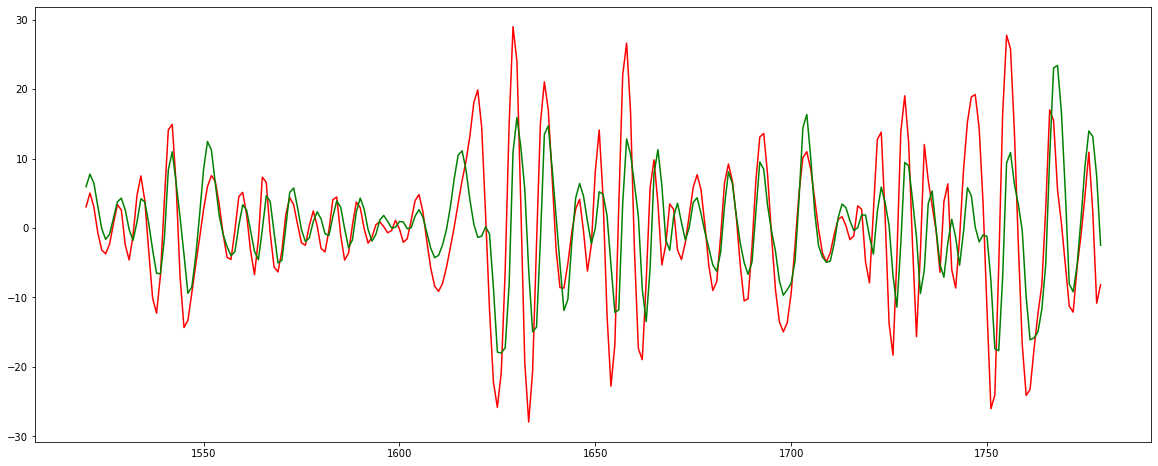

Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-21 17:19:26.848469: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_292030_292515_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_293222' and '__inference___backward_standard_lstm_292030_292515' both implement 'lstm_56b47e44-99ea-47b4-894e-5a43accf8d98' but their signatures do not match.


1440/1500 [===========================>..] - ETA: 0s - loss: 1.1275

2022-06-21 17:19:30.215622: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_293618' and '__inference_standard_lstm_293507_specialized_for_sequential_21_lstm_42_StatefulPartitionedCall_at___inference_distributed_function_294305' both implement 'lstm_4804c65c-6010-458d-b52f-5cde1f87a535' but their signatures do not match.


1500/1500 [==============================] - 5s 3ms/sample - loss: 1.1137 - val_loss: 0.2097
Epoch 2/50
1500/1500 [==============================] - 1s 990us/sample - loss: 1.0533 - val_loss: 0.2162
Epoch 3/50
1500/1500 [==============================] - 1s 995us/sample - loss: 0.9945 - val_loss: 0.2172
Epoch 4/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.9240 - val_loss: 0.2192
Epoch 5/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.8481 - val_loss: 0.2191
Epoch 6/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.7776 - val_loss: 0.2201
Epoch 7/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.7144 - val_loss: 0.2121
Epoch 8/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.6578 - val_loss: 0.2056
Epoch 9/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.6015 - val_loss: 0.1810
Epoch 10/50
1500/1500 [==============================] - 2s 1ms/sample 

2022-06-21 17:20:54.340380: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_300773' and '__inference_standard_lstm_300662_specialized_for_sequential_21_lstm_43_StatefulPartitionedCall_at___inference_distributed_function_300964' both implement 'lstm_a38d4b06-b171-4485-9945-d1e2e699a94d' but their signatures do not match.


Train RMSE: 4.54
Test RMSE: 4.09


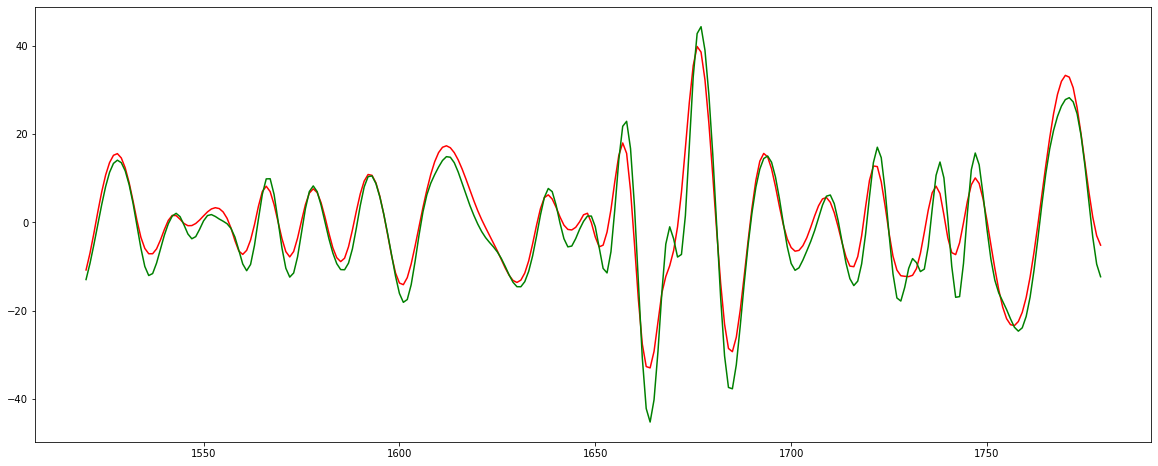

Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-21 17:20:59.720766: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_306247_306732_specialized_for_StatefulPartitionedCall_1_at___inference_distributed_function_306907' and '__inference___backward_standard_lstm_306247_306732' both implement 'lstm_a1a38c4f-aab4-4e78-8920-8125e9456788' but their signatures do not match.


1440/1500 [===========================>..] - ETA: 0s - loss: 0.9267

2022-06-21 17:21:03.105957: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_307192_specialized_for_sequential_22_lstm_44_StatefulPartitionedCall_at___inference_distributed_function_307990' and '__inference_standard_lstm_307192' both implement 'lstm_ce0996c3-a1d9-4976-9aac-937d00b1ca23' but their signatures do not match.


1500/1500 [==============================] - 8s 5ms/sample - loss: 0.9174 - val_loss: 1.5564
Epoch 2/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.8178 - val_loss: 1.3736
Epoch 3/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.6590 - val_loss: 1.2349
Epoch 4/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.5884 - val_loss: 1.1339
Epoch 5/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.5150 - val_loss: 1.0025
Epoch 6/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.4037 - val_loss: 0.7984
Epoch 7/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.2746 - val_loss: 0.6575
Epoch 8/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.2134 - val_loss: 0.5887
Epoch 9/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.1887 - val_loss: 0.5382
Epoch 10/50
1500/1500 [==============================] - 2s 1ms/sample - lo

2022-06-21 17:22:29.492446: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_313878' and '__inference_standard_lstm_313878_specialized_for_sequential_22_lstm_44_StatefulPartitionedCall_at___inference_distributed_function_314649' both implement 'lstm_079ad8f3-3cd1-4f4e-8315-923189c0a748' but their signatures do not match.


Train RMSE: 3.62
Test RMSE: 6.53


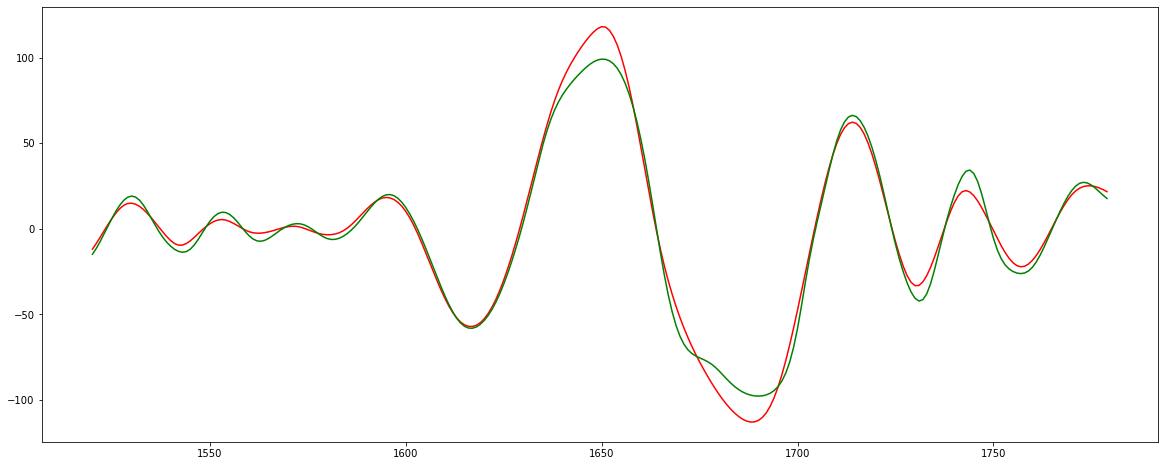

Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-21 17:22:32.062703: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_319932_320417' and '__inference___backward_standard_lstm_319932_320417_specialized_for_StatefulPartitionedCall_1_at___inference_distributed_function_320592' both implement 'lstm_486fd312-d4ad-47e9-b2ea-d60fc51c61f6' but their signatures do not match.


1440/1500 [===========================>..] - ETA: 0s - loss: 0.8759

2022-06-21 17:22:35.447345: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_321346' and '__inference_standard_lstm_321346_specialized_for_sequential_23_lstm_47_StatefulPartitionedCall_at___inference_distributed_function_321675' both implement 'lstm_70c2db3b-ba7c-448f-a62f-59854574a84f' but their signatures do not match.


1500/1500 [==============================] - 5s 3ms/sample - loss: 0.8696 - val_loss: 1.1145
Epoch 2/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.5894 - val_loss: 0.7873
Epoch 3/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.3311 - val_loss: 0.6928
Epoch 4/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.2429 - val_loss: 0.5780
Epoch 5/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.1811 - val_loss: 0.4543
Epoch 6/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.1182 - val_loss: 0.2955
Epoch 7/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0567 - val_loss: 0.1594
Epoch 8/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0326 - val_loss: 0.1260
Epoch 9/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0271 - val_loss: 0.1098
Epoch 10/50
1500/1500 [==============================] - 2s 1ms/sample - lo

2022-06-21 17:23:59.892823: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_327674' and '__inference_standard_lstm_327563_specialized_for_sequential_23_lstm_46_StatefulPartitionedCall_at___inference_distributed_function_328334' both implement 'lstm_1f0b9f9c-21a8-4e40-ba00-d6cf4841cc14' but their signatures do not match.


Train RMSE: 1.75
Test RMSE: 4.98


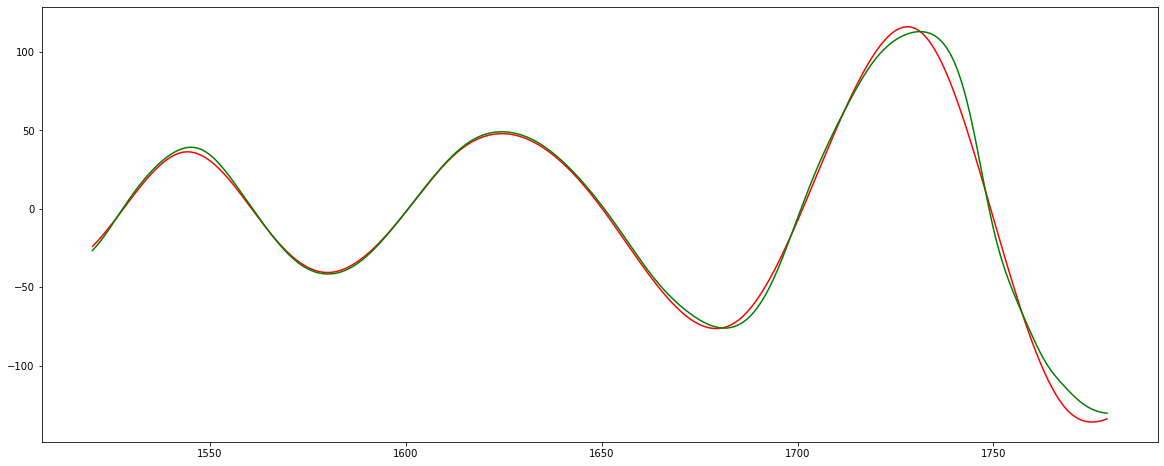

Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-21 17:24:02.784519: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_333617_334102_specialized_for_StatefulPartitionedCall_1_at___inference_distributed_function_334277' and '__inference___backward_standard_lstm_333617_334102' both implement 'lstm_a9c9a7b2-efb4-4498-bb84-88f2b159ca86' but their signatures do not match.


1440/1500 [===========================>..] - ETA: 0s - loss: 0.8041

2022-06-21 17:24:06.281573: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_334562_specialized_for_sequential_24_lstm_48_StatefulPartitionedCall_at___inference_distributed_function_335360' and '__inference_cudnn_lstm_with_fallback_334673' both implement 'lstm_27c5a448-4d84-4020-87c7-8e3ff0d89f9f' but their signatures do not match.


1500/1500 [==============================] - 6s 4ms/sample - loss: 0.7934 - val_loss: 0.1496
Epoch 2/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.2719 - val_loss: 0.1784
Epoch 3/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.1476 - val_loss: 0.1537
Epoch 4/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.1125 - val_loss: 0.1177
Epoch 5/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0866 - val_loss: 0.0810
Epoch 6/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0666 - val_loss: 0.1024
Epoch 7/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0526 - val_loss: 0.0465
Epoch 8/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0433 - val_loss: 0.0471
Epoch 9/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0364 - val_loss: 0.0465
Epoch 10/50
1500/1500 [==============================] - 2s 1ms/sample - lo

2022-06-21 17:25:30.974324: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_341828' and '__inference_standard_lstm_341717_specialized_for_sequential_24_lstm_49_StatefulPartitionedCall_at___inference_distributed_function_342019' both implement 'lstm_4820c768-7095-43b3-917f-db20ec8c9bc3' but their signatures do not match.


Train RMSE: 2.32
Test RMSE: 0.73


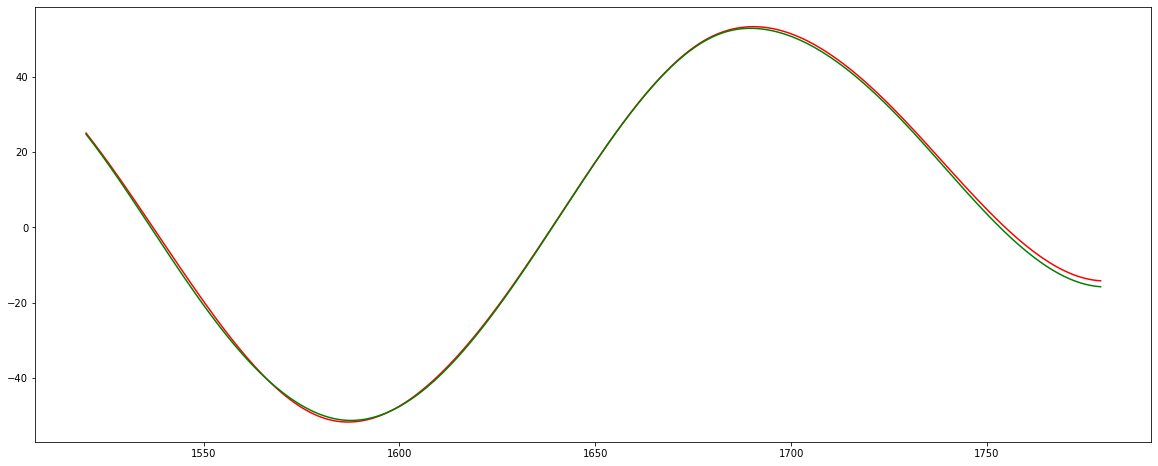

Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-21 17:25:33.600617: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_346006_346188' and '__inference___backward_standard_lstm_347302_347787_specialized_for_StatefulPartitionedCall_1_at___inference_distributed_function_347962' both implement 'lstm_04d0d6c0-ab54-4f30-81df-2c3c49f45a54' but their signatures do not match.


1440/1500 [===========================>..] - ETA: 0s - loss: 0.8628

2022-06-21 17:25:37.088267: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_348247' and '__inference_standard_lstm_348247_specialized_for_sequential_25_lstm_50_StatefulPartitionedCall_at___inference_distributed_function_349045' both implement 'lstm_fe730d12-ad3c-4d46-b3ca-56c2832c1ecb' but their signatures do not match.


1500/1500 [==============================] - 5s 4ms/sample - loss: 0.8489 - val_loss: 0.0188
Epoch 2/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.2502 - val_loss: 0.0496
Epoch 3/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0793 - val_loss: 0.0450
Epoch 4/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0541 - val_loss: 0.0265
Epoch 5/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0374 - val_loss: 0.0187
Epoch 6/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0245 - val_loss: 0.0180
Epoch 7/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0156 - val_loss: 0.0115
Epoch 8/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0102 - val_loss: 0.0058
Epoch 9/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0071 - val_loss: 0.0045
Epoch 10/50
1500/1500 [==============================] - 2s 1ms/sample - lo

2022-06-21 17:27:07.805401: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_355402' and '__inference_standard_lstm_355402_specialized_for_sequential_25_lstm_51_StatefulPartitionedCall_at___inference_distributed_function_355704' both implement 'lstm_50f05434-242e-4fd1-8aca-c25a483481cf' but their signatures do not match.


Train RMSE: 0.88
Test RMSE: 0.93


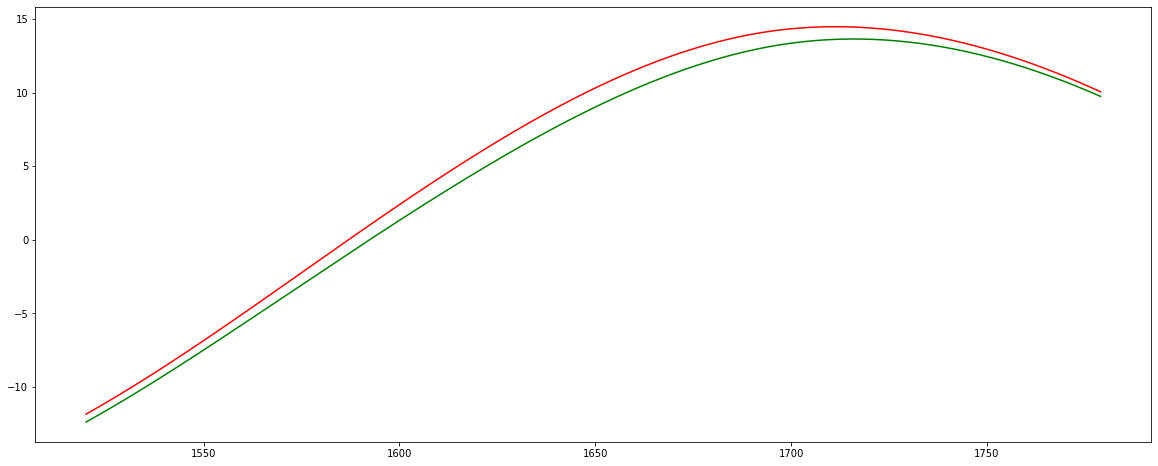

Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-21 17:27:15.206068: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_360455_360940_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_361647' and '__inference___backward_cudnn_lstm_with_fallback_360160_360342' both implement 'lstm_222aa5fa-8ab4-4c36-ae89-eacd323aab17' but their signatures do not match.


1440/1500 [===========================>..] - ETA: 0s - loss: 0.6415

2022-06-21 17:27:18.732780: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_361932' and '__inference_standard_lstm_361932_specialized_for_sequential_26_lstm_52_StatefulPartitionedCall_at___inference_distributed_function_362730' both implement 'lstm_6ebbdae4-2a95-45a8-93fd-80a4dd314689' but their signatures do not match.


1500/1500 [==============================] - 5s 4ms/sample - loss: 0.6366 - val_loss: 2.4150
Epoch 2/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.2701 - val_loss: 1.5668
Epoch 3/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0937 - val_loss: 0.6830
Epoch 4/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0506 - val_loss: 0.4737
Epoch 5/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0377 - val_loss: 0.3571
Epoch 6/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0273 - val_loss: 0.2797
Epoch 7/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0189 - val_loss: 0.2389
Epoch 8/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0114 - val_loss: 0.1746
Epoch 9/50
1500/1500 [==============================] - 3s 2ms/sample - loss: 0.0063 - val_loss: 0.1200
Epoch 10/50
1500/1500 [==============================] - 2s 2ms/sample - lo

2022-06-21 17:31:10.245530: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_369198' and '__inference_standard_lstm_369087_specialized_for_sequential_26_lstm_53_StatefulPartitionedCall_at___inference_distributed_function_369389' both implement 'lstm_44ad8683-5713-44d6-b424-6d1e4d284da0' but their signatures do not match.


Train RMSE: 0.30
Test RMSE: 1.38


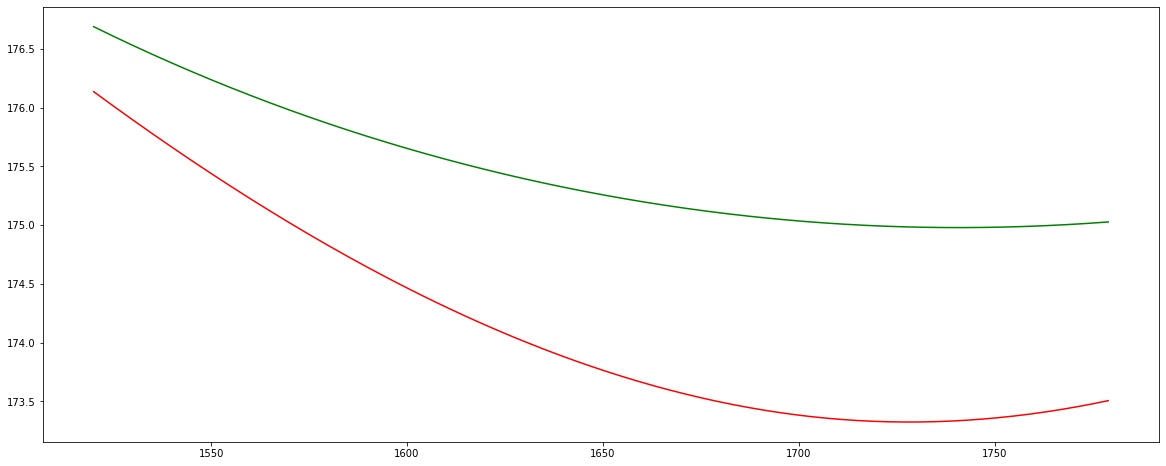

In [272]:
test_predict_df = pd.DataFrame()
for i in imfs.columns:
    test_predict_df[i] = pd.DataFrame(LSTM_model(imfs[[i]],20,1,i))

In [274]:
test_predict_df['sum'] = test_predict_df[['imf0','imf1','imf2','imf3','imf4','imf5','imf6','imf7',]].sum(axis = 1)
test_predict_df['denoise1'] = test_predict_df[['imf1','imf2','imf3','imf4','imf5','imf6','imf7']].sum(axis = 1)
test_predict_df['denoise2'] = test_predict_df[['imf2','imf3','imf4','imf5','imf6','imf7']].sum(axis = 1)

In [275]:
test_predict_df

,imf0,imf1,imf2,imf3,imf4,imf5,imf6,imf7,sum,denoise1,denoise2
0,1.447893,5.950875,-12.920908,-14.867601,-26.605059,24.768263,-12.383732,176.689514,142.079254,140.631348,134.680481
1,1.231392,7.772366,-9.291080,-11.373451,-23.851688,23.428247,-12.235184,176.673157,152.353760,151.122360,143.350006
2,0.537098,6.462078,-5.021189,-7.310398,-20.785999,22.057566,-12.085367,176.656891,160.510681,159.973587,153.511505
3,-0.007579,3.142607,-0.469076,-2.877468,-17.454809,20.658113,-11.934307,176.640717,167.698196,167.705780,164.563171
4,0.108114,-0.078692,4.048413,1.691936,-13.915856,19.232033,-11.782030,176.624634,175.928558,175.820435,175.899124
...,...,...,...,...,...,...,...,...,...,...,...
255,-0.042027,8.819925,12.854012,25.544333,-127.553467,-15.101950,10.192842,175.017502,89.731163,89.773193,80.953270
256,0.107988,13.985212,4.674060,23.777966,-128.614670,-15.347726,10.081235,175.019775,83.683846,83.575859,69.590645
257,-0.009066,13.186036,-3.329965,21.719423,-129.414856,-15.544588,9.968075,175.022110,71.597168,71.606232,58.420197
258,0.108133,7.514368,-9.435765,19.624769,-129.972214,-15.691457,9.853375,175.024506,57.025719,56.917580,49.403214


In [276]:
testScore_sum = math.sqrt(mean_squared_error(y_test, test_predict_df['sum']))
print('Test RMSE: %.2f' % (testScore_sum))

testScore_denoise1 = math.sqrt(mean_squared_error(y_test, test_predict_df['denoise1']))
print('Test RMSE: %.2f' % (testScore_denoise1))

testScore_denoise2 = math.sqrt(mean_squared_error(y_test, test_predict_df['denoise2']))
print('test RMSE: %.2f' % (testScore_denoise2))

Test RMSE: 13.68
Test RMSE: 14.19
test RMSE: 15.32


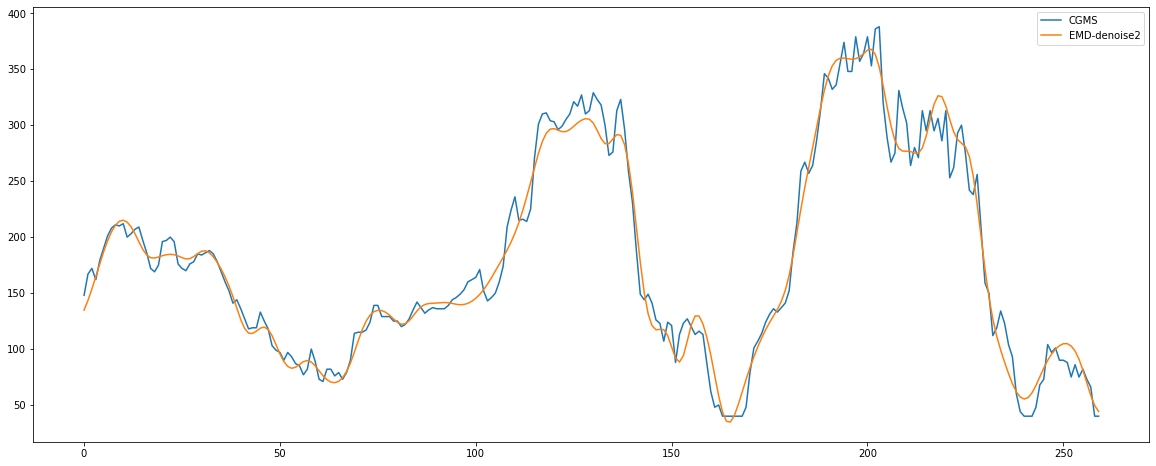

In [277]:
plt.figure(figsize=(20,8))
plt.plot(y_test,label = 'CGMS')
#plt.plot(test_predict_df['sum'],label = 'EMD')
#plt.plot(test_predict_df['denoise1'],label = 'EMD-denoise1')
plt.plot(test_predict_df['denoise2'],label = 'EMD-denoise2')
plt.legend()

# denoise data and generat data + LSTM

In [35]:
denoise_df = pd.DataFrame()
denoise_df['denoise1'] = imfs[['imf1','imf2','imf3','imf4','imf5','imf6','imf7']].sum(axis = 1)
denoise_df['denoise2'] = imfs[['imf2','imf3','imf4','imf5','imf6','imf7']].sum(axis = 1)
denoise_df

,denoise1,denoise2
0,40.102581,44.046535
1,39.234574,43.828908
2,40.921463,43.795436
3,44.036228,43.969034
4,47.440220,44.382706
...,...,...
1775,77.847714,73.253824
1776,76.994592,66.062032
1777,62.042091,59.654437
1778,43.964227,54.795375


Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-20 14:02:10.455489: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_127124_127609' and '__inference___backward_standard_lstm_127124_127609_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_128242' both implement 'lstm_41718ac8-6918-4dcd-8945-962a5398e54e' but their signatures do not match.


1440/1500 [===========================>..] - ETA: 0s - loss: 0.7928

2022-06-20 14:02:13.781649: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_128527_specialized_for_sequential_9_lstm_18_StatefulPartitionedCall_at___inference_distributed_function_129325' and '__inference_cudnn_lstm_with_fallback_128638' both implement 'lstm_2d46f5f2-1cc9-4ddc-9b5b-4099b416d0f7' but their signatures do not match.


1500/1500 [==============================] - 5s 3ms/sample - loss: 0.7836 - val_loss: 0.6092
Epoch 2/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.4612 - val_loss: 0.4972
Epoch 3/50
1500/1500 [==============================] - 1s 997us/sample - loss: 0.3360 - val_loss: 0.4109
Epoch 4/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.2873 - val_loss: 0.3769
Epoch 5/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.2563 - val_loss: 0.3020
Epoch 6/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.2339 - val_loss: 0.2416
Epoch 7/50
1500/1500 [==============================] - 1s 990us/sample - loss: 0.2183 - val_loss: 0.2341
Epoch 8/50
1500/1500 [==============================] - 1s 997us/sample - loss: 0.2035 - val_loss: 0.1964
Epoch 9/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.1878 - val_loss: 0.1804
Epoch 10/50
1500/1500 [==============================] - 1s 994us/sam

2022-06-20 14:03:36.345674: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_135213' and '__inference_standard_lstm_135213_specialized_for_sequential_9_lstm_18_StatefulPartitionedCall_at___inference_distributed_function_135984' both implement 'lstm_fb3fc61f-da29-478d-93e8-8b32086525f9' but their signatures do not match.


Train RMSE: 15.13
Test RMSE: 19.22


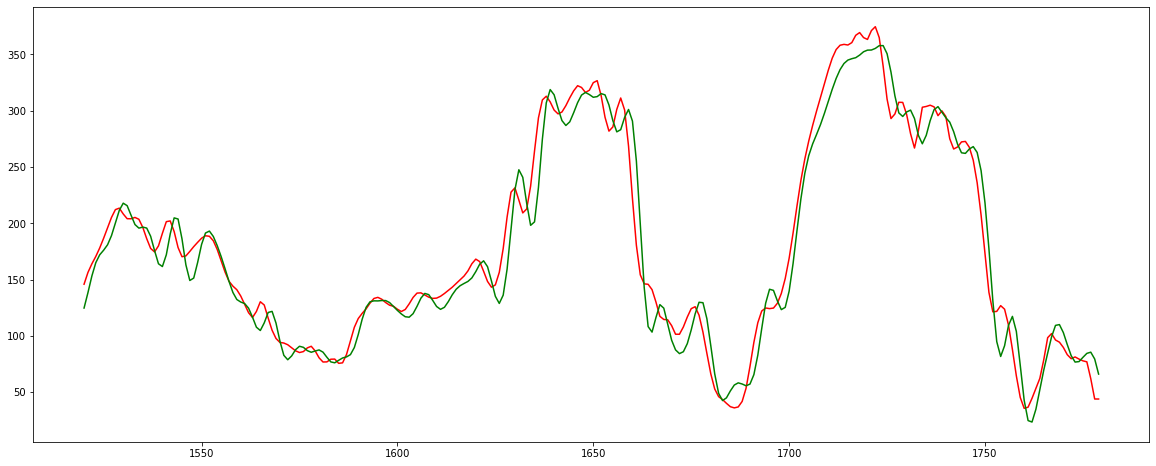

Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-20 14:03:39.829840: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_140438_140620' and '__inference___backward_standard_lstm_140733_141218_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_141851' both implement 'lstm_e1761773-ffe2-4273-a49d-deb5a784a3ee' but their signatures do not match.


1472/1500 [============================>.] - ETA: 0s - loss: 1.0275

2022-06-20 14:03:43.240913: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_142247' and '__inference_standard_lstm_142136_specialized_for_sequential_10_lstm_20_StatefulPartitionedCall_at___inference_distributed_function_142934' both implement 'lstm_3ee3a18e-0e99-427c-972d-a1ec0adaf335' but their signatures do not match.


1500/1500 [==============================] - 6s 4ms/sample - loss: 1.0246 - val_loss: 0.8078
Epoch 2/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.7631 - val_loss: 0.5270
Epoch 3/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.5017 - val_loss: 0.4036
Epoch 4/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.3487 - val_loss: 0.3025
Epoch 5/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.2413 - val_loss: 0.2438
Epoch 6/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.1841 - val_loss: 0.2308
Epoch 7/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.1557 - val_loss: 0.1893
Epoch 8/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.1364 - val_loss: 0.1459
Epoch 9/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.1232 - val_loss: 0.1335
Epoch 10/50
1500/1500 [==============================] - 2s 1ms/sample - lo

2022-06-20 14:05:11.705783: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_148822_specialized_for_sequential_10_lstm_20_StatefulPartitionedCall_at___inference_distributed_function_149593' and '__inference_cudnn_lstm_with_fallback_148933' both implement 'lstm_f75e1949-8b3f-43f0-9469-3e1d86fcda80' but their signatures do not match.


Train RMSE: 7.14
Test RMSE: 8.76


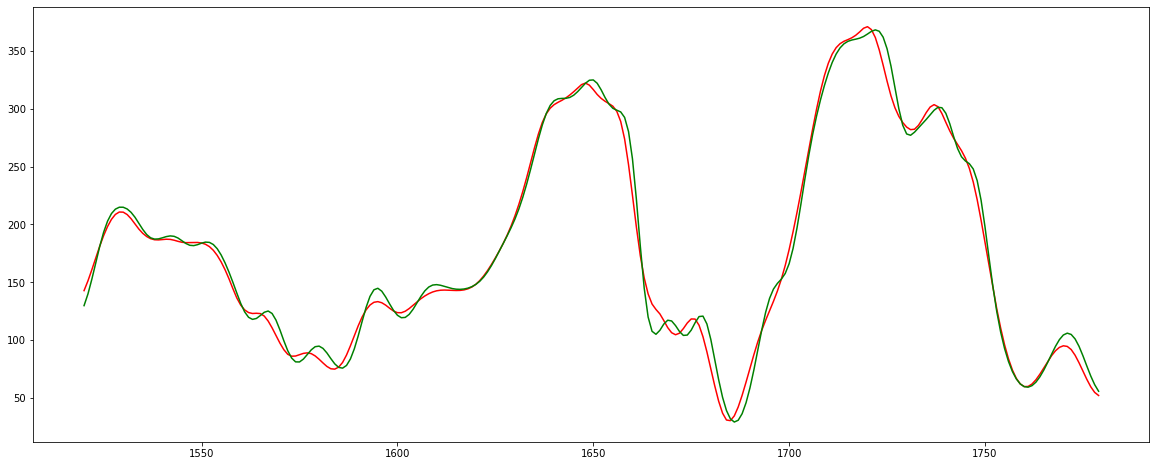

In [36]:
denoise_predict_df = pd.DataFrame()
for i in denoise_df.columns:
    denoise_predict_df[i] = pd.DataFrame(LSTM_model(denoise_df[[i]],20,1,i))

In [37]:
testScore_sum_denoise1 = math.sqrt(mean_squared_error(y_test, denoise_predict_df['denoise1']))
print('Test RMSE: %.2f' % (testScore_sum_denoise1))

testScore_sum_denoise2 = math.sqrt(mean_squared_error(y_test, denoise_predict_df['denoise2']))
print('test RMSE: %.2f' % (testScore_sum_denoise2))

Test RMSE: 21.69
test RMSE: 16.72


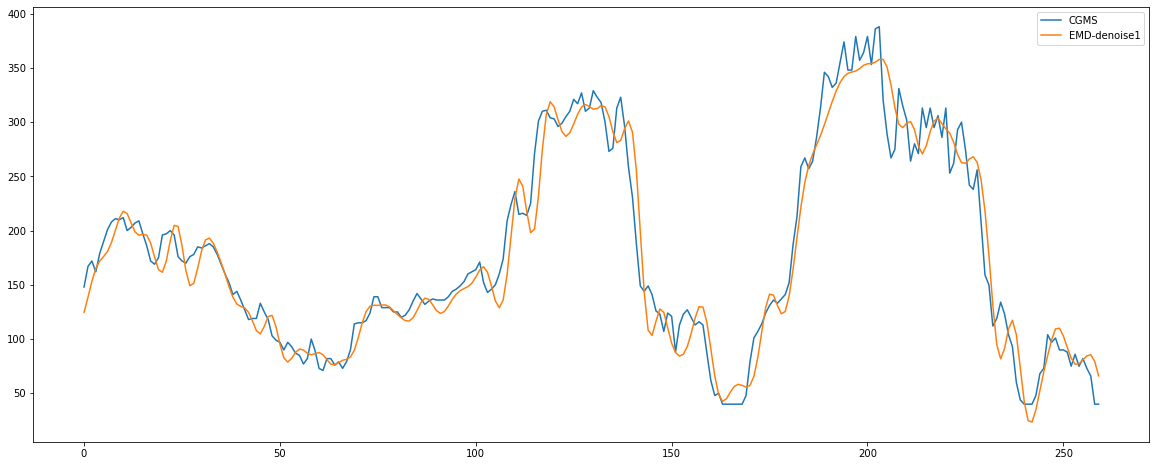

In [44]:
plt.figure(figsize=(20,8))
plt.plot(y_test,label = 'CGMS')
plt.plot(denoise_predict_df['denoise1'],label = 'EMD-denoise1')
#plt.plot(denoise_predict_df['denoise2'],label = 'EMD-denoise2')
plt.legend()